# Forecasting: Number of Antidiabetic Drug Prescription in Australia

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statistical Modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
# Statistical Modeling API
import statsmodels.api as sm

# Iterators Optimizer
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

# Warnings
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

#### Loading Data

In [4]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/AusAntidiabeticDrug.csv')
df.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [5]:
# Checking Tail
df.tail()

,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [6]:
df.shape

(204, 2)

#### The Series & It's Components

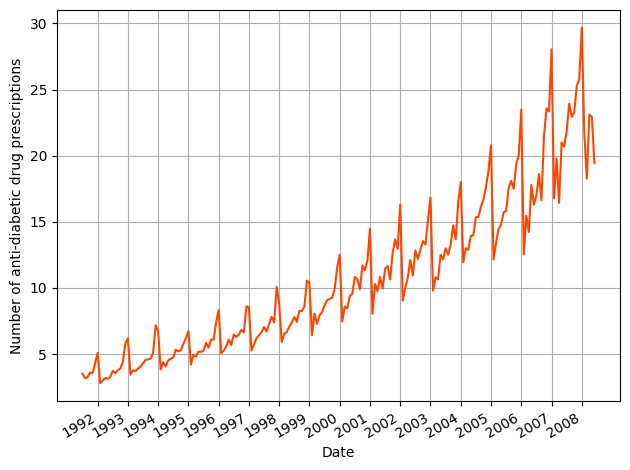

In [7]:
fig, ax = plt.subplots()

ax.plot(df.y, color='orangered')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.grid(True)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

#### Applying Seasonal Trend Decomposition LOESS(STL)

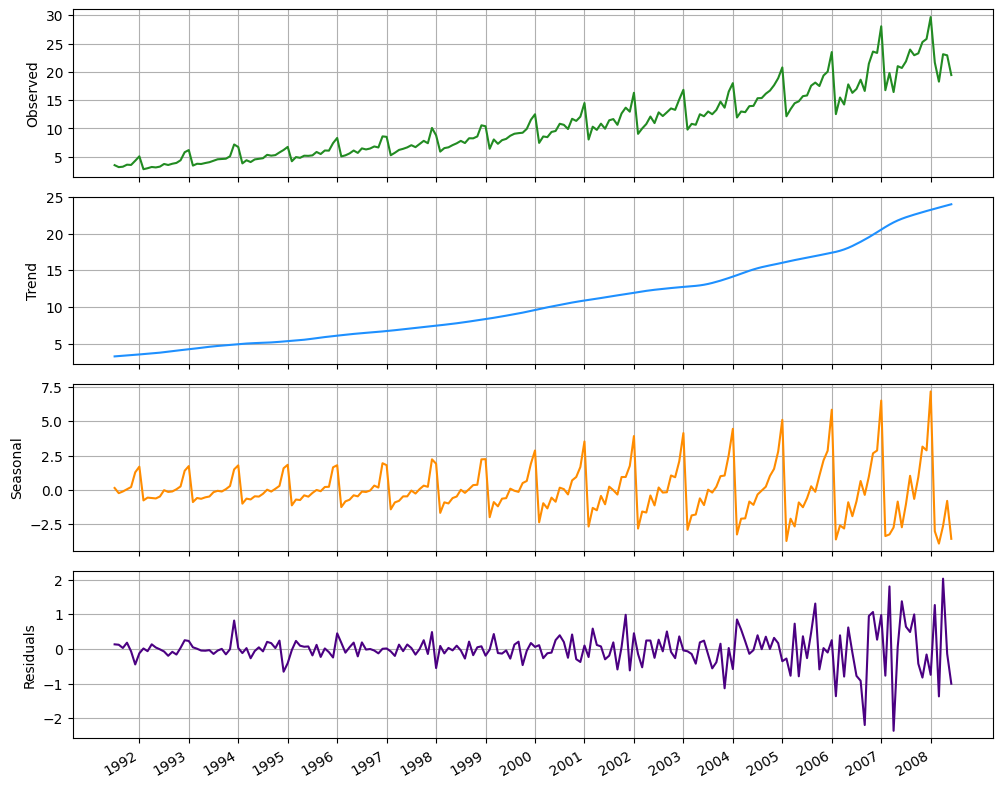

In [8]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed, color='forestgreen')
ax1.set_ylabel('Observed')
ax1.grid(True)

ax2.plot(decomposition.trend, color='dodgerblue')
ax2.set_ylabel('Trend')
ax2.grid(True)

ax3.plot(decomposition.seasonal, color='darkorange')
ax3.set_ylabel('Seasonal')
ax3.grid(True)

ax4.plot(decomposition.resid, color='indigo')
ax4.set_ylabel('Residuals')
ax4.grid(True)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

#### Model Processing Procedure

##### Dickey-Fuller Test

In [9]:
ad_fuller_result = adfuller(df.y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306737
p-value: 1.0


##### 1st Order Differencing Procedure

In [10]:
y_diff = np.diff(df.y, n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474496953
p-value: 0.1166534168646986


##### Applying Seasonal Differencing

In [11]:
y_diff_seasonal_diff = np.diff(y_diff, n=12)

ad_fuller_result = adfuller(y_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.848440095484218
p-value: 0.0


#### Peforming Model Selection

##### Train/Test Splits

In [12]:
train = df.y[:168]
test = df.y[168:]

# Finding The Optimal Values
print(len(test))

36


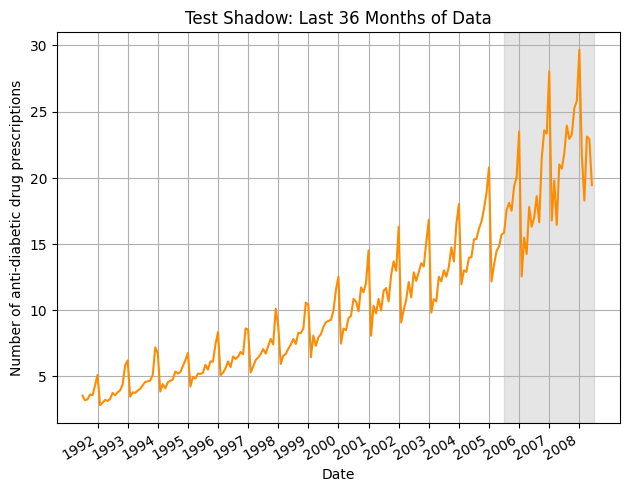

In [13]:
fig, ax = plt.subplots()

ax.plot(df.y, color='darkorange')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)
ax.grid(True)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Test Shadow: Last 36 Months of Data')
plt.show()

##### Setting Optimized SARIMA Function

In [14]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

##### Setting values (p,q) (P,Q) 

In [15]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
# Seasonal Order
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

# Differentation
d = 1
D = 1
# Seasonal - Monthly 
s = 12

##### Retrieving the best AIC 

In [16]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.218586
2,"(3, 3, 1, 3)",271.463835
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.221736
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


##### The Optimal Model is : SARIMA (3, 1,1)(1, 1,3)12

#### Residual Analysis

In [17]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Sat, 02 Mar 2024   AIC                            270.951
Time:                                            10:29:35   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

##### LJung-Box Test

In [18]:
# Running the Ljung-Box test on the residuals
residuals = SARIMA_model_fit.resid
results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.508710
2     0.730709
3     0.885830
4     0.688373
5     0.707616
6     0.758615
7     0.189593
8     0.225903
9     0.221656
10    0.286029
Name: lb_pvalue, dtype: float64


#### Diagnose Visualization

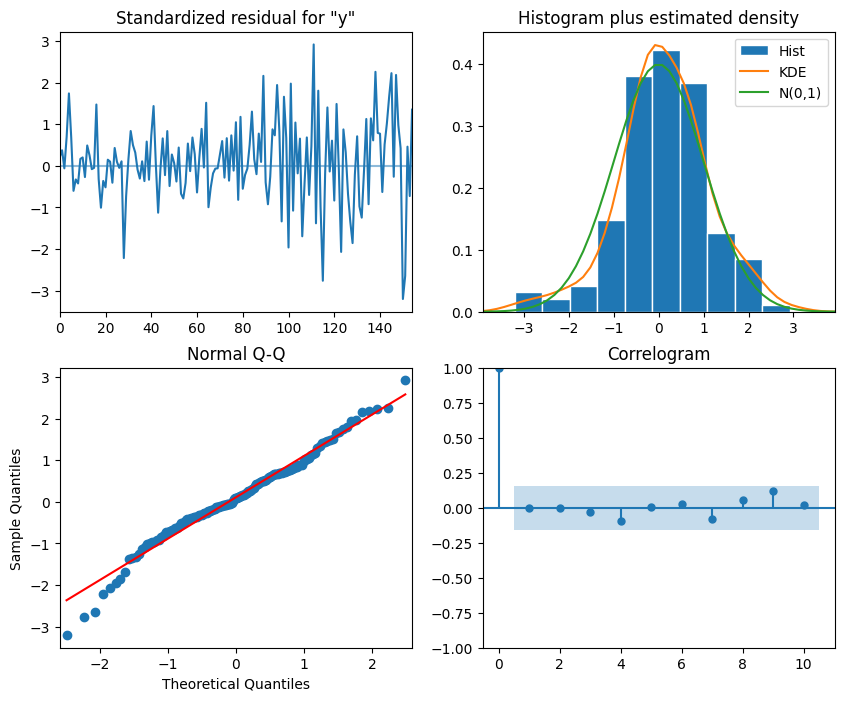

In [19]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

### Forecasting

##### Setting Rolling Forecast Function

In [20]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [21]:
pred_df = df[168:]

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [22]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [23]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.752184
169,2005-08-01,17.554701,15.370764,16.688290
170,2005-09-01,18.100864,16.142005,17.191185
171,2005-10-01,17.496668,16.685754,18.091060
172,2005-11-01,19.347265,17.636728,18.664520
173,2005-12-01,20.031291,18.869325,19.947019
174,2006-01-01,23.486694,20.778723,22.082860
175,2006-02-01,12.536987,12.154552,13.746164
176,2006-03-01,15.467018,13.402392,15.081318
177,2006-04-01,14.233539,14.459239,15.657607


##### Contrasting Model's Performance

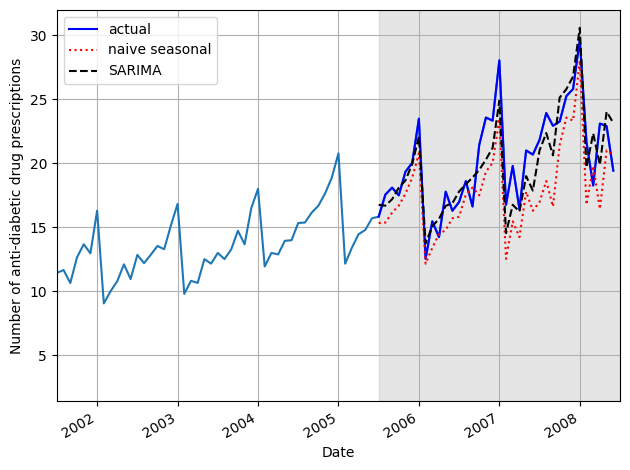

In [24]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)
ax.grid(True)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

#### Mean Absolute Percentage Error (MAPE) Evaluation

#### MAPE Function

In [25]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.894421285540225


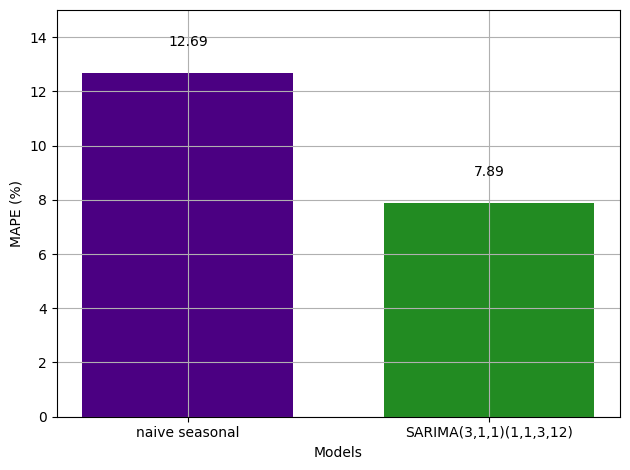

In [28]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(3,1,1)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.7, color=['indigo', 'forestgreen'])
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)
ax.grid(True)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()